In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 976.9/976.9 kB 26.2 MB/s eta 0:00:0000:01


In [2]:
import os
import cv2
import torch
from ultralytics import YOLO
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import os

MODEL_PATH = "best.pt"
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH}")

# Verify YAML file path
DATA_YAML_PATH = "data.yaml"
if not os.path.exists(DATA_YAML_PATH):
    raise FileNotFoundError(f"YAML file not found at {DATA_YAML_PATH}")

# Load YOLO Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = YOLO(MODEL_PATH).to(device)

print(f"Model loaded successfully on {device}!")

Model loaded successfully on cpu!


In [ ]:
# Clear output folder
# import os

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working/'
# remove_folder_contents(folder_path)
# os.rmdir(folder_path)


In [4]:
import os
import cv2
import yaml
import json
from ultralytics import YOLO

# Paths
TEST_IMAGES_PATH = "/kaggle/input/test-image"
CROPPED_OUTPUT_PATH = "/kaggle/working/cropped_images"
BBOX_OUTPUT_PATH = "/kaggle/working/bbox_images"
JSON_OUTPUT_PATH = "/kaggle/working/ingredient_counts.json"

# Load YOLO Model
MODEL_PATH = "/kaggle/input/yolo_detection/pytorch/default/1/best.pt"
model = YOLO(MODEL_PATH)

# Ensure output directories exist
os.makedirs(CROPPED_OUTPUT_PATH, exist_ok=True)
os.makedirs(BBOX_OUTPUT_PATH, exist_ok=True)

# Load YAML file
DATA_YAML_PATH = "/kaggle/input/yaml_file/pytorch/default/1/data.yaml"
with open(DATA_YAML_PATH, "r") as file:
    data_yaml = yaml.safe_load(file)

# Dictionary to store ingredient counts
ingredient_counts = {}

# Process each image
for image_name in os.listdir(TEST_IMAGES_PATH):
    image_path = os.path.join(TEST_IMAGES_PATH, image_name)

    # Load Image
    image = cv2.imread(image_path)
    if image is None:
        print(f"⚠️ Skipping {image_name}: Unable to read image.")
        continue

    # Run YOLO Inference
    results = model(image)

    # Copy image for bounding box drawing
    bbox_image = image.copy()

    # Loop through each detected object
    for i, obj in enumerate(results[0].boxes):
        x1, y1, x2, y2 = map(int, obj.xyxy[0])  # Get bounding box coordinates
        class_id = int(obj.cls[0])  # Get class ID

        # Ensure 'names' key exists in YAML
        if "names" not in data_yaml:
            print(f"⚠️ 'names' key missing in YAML. Skipping object {i} in {image_name}.")
            continue
        
        class_name = data_yaml["names"][class_id]  # Get class label

        # Update ingredient count
        if class_name not in ingredient_counts:
            ingredient_counts[class_name] = 0
        ingredient_counts[class_name] += 1

        # Create class directory if not exists
        class_dir = os.path.join(CROPPED_OUTPUT_PATH, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Crop the detected object
        cropped_image = image[y1:y2, x1:x2]

        # Save cropped object with unique name
        cropped_save_path = os.path.join(class_dir, f"{image_name.split('.')[0]}_{i}.jpg")
        cv2.imwrite(cropped_save_path, cropped_image)

        # Draw bounding box on the original image
        cv2.rectangle(bbox_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(bbox_image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Save image with bounding boxes
    bbox_save_path = os.path.join(BBOX_OUTPUT_PATH, image_name)
    cv2.imwrite(bbox_save_path, bbox_image)

    print(f"✅ Processed {image_name}")

# Save ingredient counts to a JSON file
with open(JSON_OUTPUT_PATH, "w") as json_file:
    json.dump(ingredient_counts, json_file, indent=4)

print("🎉 All images processed! Cropped images, bounding box images, and ingredient counts saved successfully!")



0: 640x640 4 cabbages, 4 potatos, 12 tomatos, 224.6ms
Speed: 22.6ms preprocess, 224.6ms inference, 22.3ms postprocess per image at shape (1, 3, 640, 640)
✅ Processed 2.jpg
🎉 All images processed! Cropped images, bounding box images, and ingredient counts saved successfully!


In [5]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
import torch.nn as nn

In [ ]:
# checkpoint = torch.load(CLASSIFIER_MODEL_PATH, map_location=device)
# print(checkpoint.keys())

In [6]:
CLASSIFIER_MODEL_PATH = "/kaggle/input/classification_weights/pytorch/default/1/efficientnet_fruitveg_binary.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# Create a model with the correct structure to match the saved weights
model_classification = models.efficientnet_v2_s(pretrained=False)

# Modify the classifier to match the exact dimensions in the saved weights
model_classification.classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=512),  # First layer matches [512, 1280]
    nn.SiLU(),  # Assuming this activation was used
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=512, out_features=1)  # Output layer matches [1, 512]
)

# Load the weights
model_classification.load_state_dict(torch.load(CLASSIFIER_MODEL_PATH, map_location=device))
model_classification.to(device)
model_classification.eval()

# Since the output is a single value (not 2 classes), you'll need to use sigmoid for binary classification
def predict(image):
    with torch.no_grad():
        output = model_classification(image)
        # Apply sigmoid to get probability
        prob = torch.sigmoid(output)
        # Convert to binary prediction (0 = Rotten, 1 = Fresh or vice versa depending on your training)
        pred = (prob > 0.5).float()
        return pred, prob

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the saved state dict
state_dict = torch.load(CLASSIFIER_MODEL_PATH, map_location=device)

# Create new model with 2 outputs
model_classification = models.efficientnet_v2_s(pretrained=False)
model_classification.classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=512),
    nn.SiLU(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=512, out_features=2)
)

# Create a new state dict with the modified weights
new_state_dict = {}
for key, value in state_dict.items():
    if key == "classifier.3.weight":
        new_weight = torch.zeros(2, 512)
        new_weight[0] = value
        new_weight[1] = -value
        new_state_dict[key] = new_weight
    elif key == "classifier.3.bias":
        new_bias = torch.zeros(2)
        new_bias[0] = value
        new_bias[1] = -value
        new_state_dict[key] = new_bias
    else:
        new_state_dict[key] = value

# Load the modified state dict
with torch.no_grad():  # Prevent unnecessary computation
    model_classification.load_state_dict(new_state_dict)
    model_classification.to(device)
    model_classification.eval()


In [9]:
CLASS_LABELS = ["Fresh", "Rotten"]

# Define Preprocessing for Classification Model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

📊 CLASSIFICATION RESULTS 📊
🍎 2_1.jpg                        → Rotten (Confidence: 1.00)


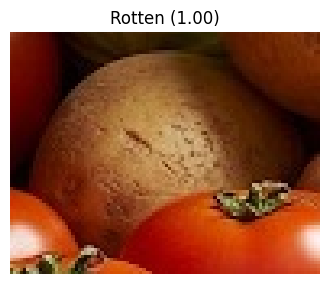

🍏 2_15.jpg                       → Fresh  (Confidence: 0.96)


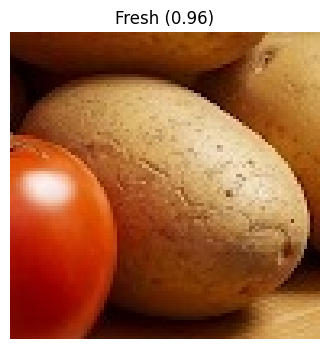

🍏 2_18.jpg                       → Fresh  (Confidence: 1.00)


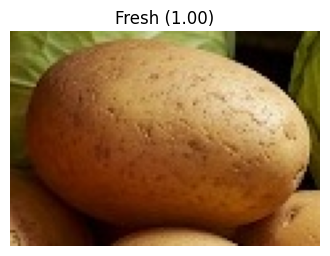

🍏 2_13.jpg                       → Fresh  (Confidence: 0.99)


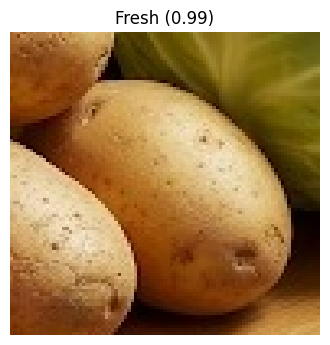

🍏 2_10.jpg                       → Fresh  (Confidence: 0.92)


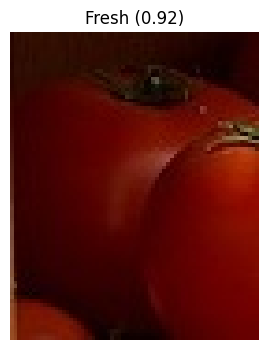

🍏 2_8.jpg                        → Fresh  (Confidence: 1.00)


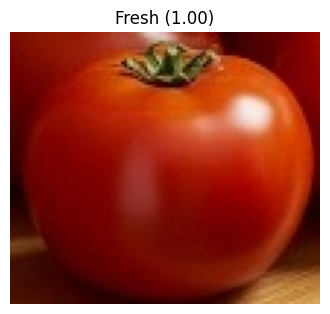

🍏 2_9.jpg                        → Fresh  (Confidence: 1.00)


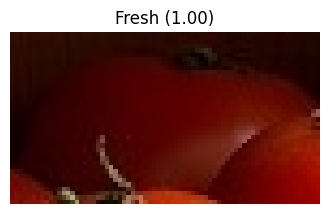

🍏 2_3.jpg                        → Fresh  (Confidence: 1.00)


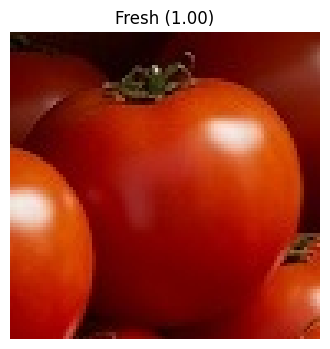

🍏 2_19.jpg                       → Fresh  (Confidence: 1.00)


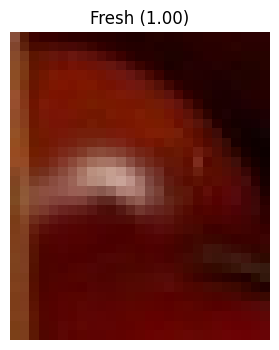

🍏 2_7.jpg                        → Fresh  (Confidence: 1.00)


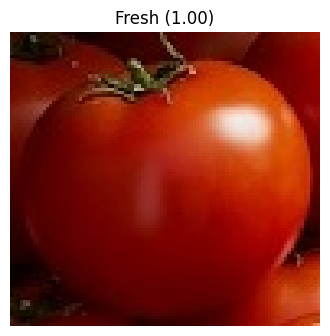

🍏 2_11.jpg                       → Fresh  (Confidence: 1.00)


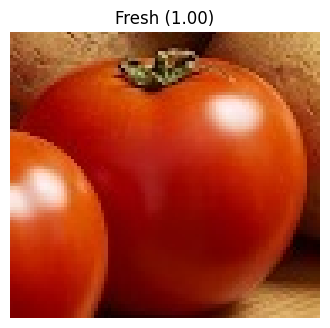

🍏 2_14.jpg                       → Fresh  (Confidence: 0.77)


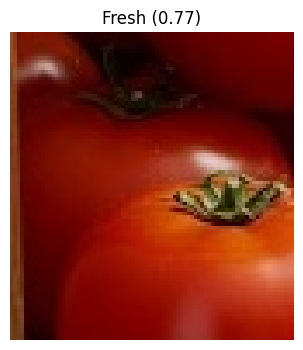

🍏 2_16.jpg                       → Fresh  (Confidence: 1.00)


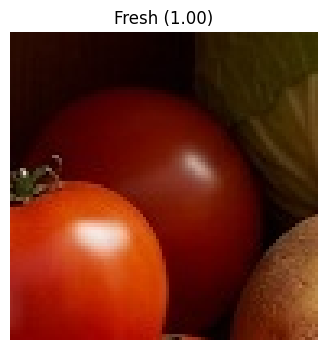

🍏 2_6.jpg                        → Fresh  (Confidence: 1.00)


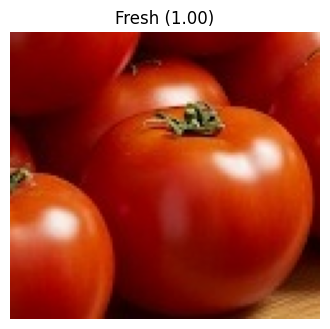

🍏 2_5.jpg                        → Fresh  (Confidence: 1.00)


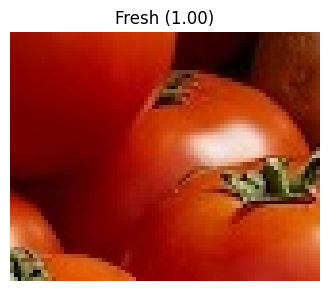

🍏 2_4.jpg                        → Fresh  (Confidence: 1.00)


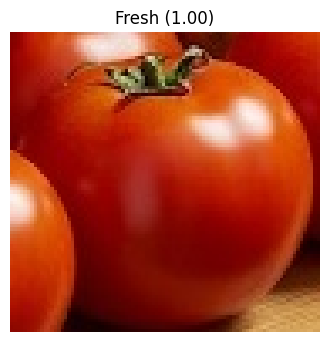

🍎 2_0.jpg                        → Rotten (Confidence: 0.68)


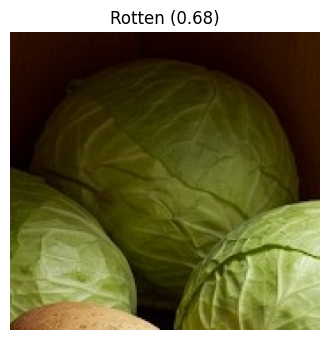

🍎 2_12.jpg                       → Rotten (Confidence: 0.99)


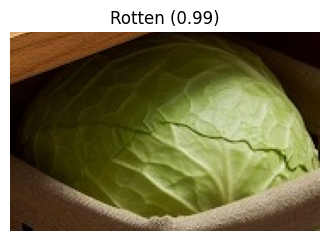

🍏 2_17.jpg                       → Fresh  (Confidence: 1.00)


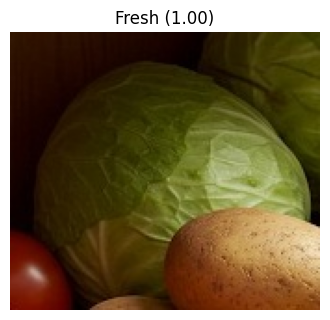

🍏 2_2.jpg                        → Fresh  (Confidence: 1.00)


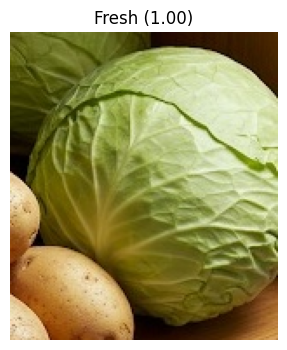


📊 SUMMARY 📊
Total images processed: 20
Fresh: 17 (85.0%)
Rotten: 3 (15.0%)
🎉 All images processed! Classification results saved successfully!


In [10]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

TEST_IMAGES_PATH = "/kaggle/working/cropped_images"
CROPPED_OUTPUT_PATH = "/kaggle/working/classified_crops"
BBOX_OUTPUT_PATH = "/kaggle/working/detection_results"

# Make directories if they don't exist
os.makedirs(CROPPED_OUTPUT_PATH, exist_ok=True)
os.makedirs(BBOX_OUTPUT_PATH, exist_ok=True)

# Define transform for the classification model
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define class labels for your binary classifier
CLASS_LABELS = ["Rotten", "Fresh"]  

# Initialize counters for summary
total_images = 0
fresh_count = 0
rotten_count = 0

print("📊 CLASSIFICATION RESULTS 📊")
print("============================")

for root, dirs, files in os.walk(TEST_IMAGES_PATH):
    for image_name in files:
        if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
            
        image_path = os.path.join(root, image_name)
        total_images += 1
        
        # Load Image
        image = cv2.imread(image_path)
        if image is None:
            print(f"⚠️ Skipping {image_name}: Unable to read image.")
            continue
        
        # Convert image to PIL format for model input
        pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        input_tensor = transform(pil_image).unsqueeze(0).to(device)
        
        # Get classification result
        with torch.no_grad():
            outputs = model_classification(input_tensor)
            
            # Binary classification with one output neuron
            if outputs.shape[1] == 1:
                pred_prob = torch.sigmoid(outputs).item()
                pred = int(pred_prob > 0.5)
                confidence = pred_prob if pred == 1 else (1 - pred_prob)
            else:  # Classification with 2 output neurons
                probabilities = torch.softmax(outputs, dim=1)
                confidence, pred = torch.max(probabilities, 1)
                confidence = confidence.item()
                pred = pred.item()
            
            pred_label = CLASS_LABELS[pred]
            
            # Update counters
            if pred_label == "Fresh":
                fresh_count += 1
            else:
                rotten_count += 1
        
        # Save labeled image with confidence score
        result_save_path = os.path.join(BBOX_OUTPUT_PATH, image_name)
        cv2.putText(image, f"{pred_label} ({confidence:.2f})", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0) if pred_label == "Fresh" else (0, 0, 255), 2)
        cv2.imwrite(result_save_path, image)

        # Save classified image in the respective folder
        class_dir = os.path.join(CROPPED_OUTPUT_PATH, pred_label)
        os.makedirs(class_dir, exist_ok=True)
        classified_save_path = os.path.join(class_dir, image_name)
        cv2.imwrite(classified_save_path, image)
        
        # Print classification result
        emoji = "🍏" if pred_label == "Fresh" else "🍎"
        print(f"{emoji} {image_name:<30} → {pred_label:<6} (Confidence: {confidence:.2f})")

        # ✅ **Display Image with Classification Result**
        plt.figure(figsize=(4, 4))
        plt.imshow(pil_image)
        plt.title(f"{pred_label} ({confidence:.2f})")
        plt.axis("off")
        plt.show()

# Print summary
print("\n============================")
print("📊 SUMMARY 📊")
print(f"Total images processed: {total_images}")
print(f"Fresh: {fresh_count} ({fresh_count/total_images*100:.1f}%)")
print(f"Rotten: {rotten_count} ({rotten_count/total_images*100:.1f}%)")
print("============================")
print("🎉 All images processed! Classification results saved successfully!")
